In [1]:
import os
import time
import warnings
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from deepMNN import correct_scanpy
from metrics import compute_entropy, silhouette_coeff_ASW

warnings.filterwarnings("ignore")

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100)
sc.settings.set_figure_params(dpi_save=300)
sc.logging.print_version_and_date()

os.environ["CUDA_VISIBLE_DEVICES"]="1"

Running Scanpy 1.7.2, on 2021-06-27 12:33.


In [2]:
# adata1 = sc.read_text('../github_code/Batch-effect-removal-benchmarking/Data/dataset5/b1_exprs.txt').T
# info1 = pd.read_csv('../github_code/Batch-effect-removal-benchmarking/Data/dataset5/b1_celltype.txt', sep='\t', index_col=0)
# adata1.obs['celltype'] = info1.CellType

# adata2 = sc.read_text('../github_code/Batch-effect-removal-benchmarking/Data/dataset5/b2_exprs.txt').T
# info2 = pd.read_csv('../github_code/Batch-effect-removal-benchmarking/Data/dataset5/b2_celltype.txt', sep='\t', index_col=0)
# adata2.obs['celltype'] = info2.CellType

# adata = adata1.concatenate(adata2)

# adata.write_h5ad('data/dataset5.h5ad')

In [2]:
adata = sc.read_h5ad('data/dataset5.h5ad')

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:,adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

normalizing by total count per cell
    finished (0:00:07): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


In [3]:
batch_names = adata.obs['batch'].value_counts().index.values
adatas = [adata[adata.obs['batch'] == batch_names[i]] for i in range(0, len(batch_names))]

# Before batch correction

In [5]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
asw_raw = silhouette_coeff_ASW(adata)
entropy_raw=compute_entropy(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:49)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)


Calculating entropy ...
use exist neighbors
Entropy calculated!


... storing 'batch' as categorical


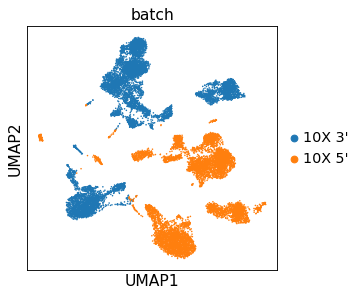

In [6]:
adata.obs['batch'] = ['10X 3\'' if i == '0' else '10X 5\'' for i in adata.obs['batch']]
sc.pl.umap(adata,color='batch',save='_figure3_raw_batch.pdf')

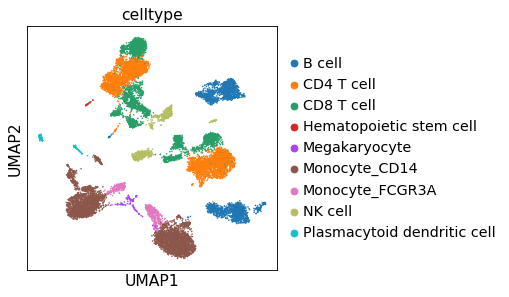

In [7]:
sc.pl.umap(adata,color='celltype',save='_figure3_raw_celltype.pdf')

In [8]:
adata.write('./processed_adata/adata_raw_fig3.h5ad')

# Batch correction using deepMNN

In [4]:
time_s = time.time()
corrected = correct_scanpy(adatas)
print('time used:', time.time()-time_s)

adata_result = corrected[0].concatenate(corrected[1:], join='inner', batch_key = 'batch')
sc.tl.pca(adata_result, svd_solver='arpack')
sc.pp.neighbors(adata_result)
sc.tl.umap(adata_result)

asw_deepMNN = silhouette_coeff_ASW(adata_result)
entropy_deepMNN=compute_entropy(adata_result)

[[0.         0.63237837]
 [0.         0.        ]]
Epoch 0, loss: 3321.544, counter: 0
Learning rate = 0.1000000
Epoch 1, loss: 1748.948, counter: 0
Learning rate = 0.1000000
Epoch 2, loss: 1451.964, counter: 0
Learning rate = 0.1000000
Epoch 3, loss: 1426.334, counter: 0
Learning rate = 0.1000000
Epoch 4, loss: 1353.389, counter: 0
Learning rate = 0.1000000
Epoch 5, loss: 1341.471, counter: 0
Learning rate = 0.1000000
Epoch 6, loss: 1389.524, counter: 1
Learning rate = 0.1000000
Epoch 7, loss: 1453.993, counter: 2
Learning rate = 0.1000000
Epoch 8, loss: 1386.161, counter: 3
Learning rate = 0.1000000
Epoch 9, loss: 1368.690, counter: 4
Learning rate = 0.1000000
Epoch 10, loss: 1346.611, counter: 5
Learning rate = 0.1000000
Epoch 11, loss: 1389.680, counter: 6
Learning rate = 0.1000000
Epoch 12, loss: 1432.795, counter: 7
Learning rate = 0.1000000
Epoch 13, loss: 1404.244, counter: 8
Learning rate = 0.1000000
Epoch 14, loss: 1379.923, counter: 9
Learning rate = 0.1000000
Epoch 15, loss

computing PCA
    with n_comps=50


time used: 38.1147186756134


    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:27)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


Calculating entropy ...
use exist neighbors
Entropy calculated!


... storing 'batch' as categorical


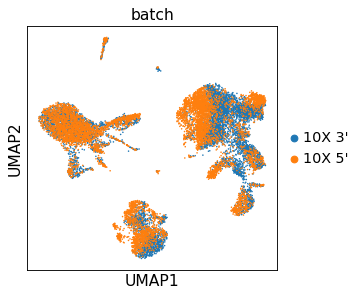

In [8]:
adata_result.obs['batch'] = ['10X 3\'' if i == '0' else '10X 5\'' for i in adata_result.obs['batch']]
sc.pl.umap(adata_result,color='batch',save='_figure3_deepMNN_batch.pdf')

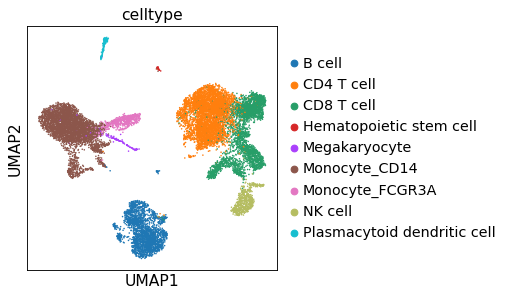

In [9]:
sc.pl.umap(adata_result,color='celltype',save='_figure3_deepMNN_celltype.pdf')

# Batch correction using Scanorama

In [10]:
import scanorama

adata = sc.read_h5ad('data/dataset5.h5ad')

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')
adata = adata[:,adata.var['highly_variable']]

adatas = [adata[adata.obs['batch'] == i,:].copy() for i in ['0','1']]

time_s = time.time()
corrected = scanorama.correct_scanpy(adatas)
print('time used:', time.time()-time_s)

corrected_dataset = corrected[0].concatenate(corrected[1:], join='inner', batch_key = 'batch')
sc.tl.pca(corrected_dataset, svd_solver='arpack')
sc.pp.neighbors(corrected_dataset)
sc.tl.umap(corrected_dataset)

asw_Scanorama = silhouette_coeff_ASW(corrected_dataset)
entropy_Scanorama=compute_entropy(corrected_dataset)

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Found 2000 genes among all datasets
[[0.         0.53926896]
 [0.         0.        ]]
Processing datasets (0, 1)


computing PCA
    on highly variable genes
    with n_comps=50


time used: 37.03662467002869


    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)


Calculating entropy ...
use exist neighbors
Entropy calculated!


... storing 'batch' as categorical


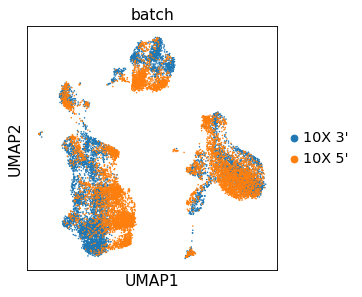

In [11]:
corrected_dataset.obs['batch'] = ['10X 3\'' if i == '0' else '10X 5\'' for i in corrected_dataset.obs['batch']]
sc.pl.umap(corrected_dataset,color='batch',save='_figure3_Scanorama_batch.pdf')

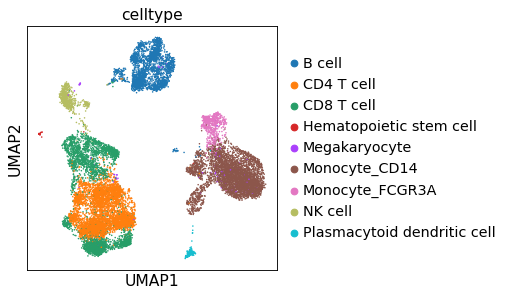

In [12]:
sc.pl.umap(corrected_dataset,color='celltype',save='_figure3_Scanorama_celltype.pdf')

In [14]:
#corrected_dataset.write('./processed_adata/adata_Scanorama_fig3.h5ad')

In [10]:
#adata_scan = sc.read_h5ad('/media/bgi/zhouruilong/deepMNN/processed_adata/fig3/adata_scanorama_fig3.h5ad')

# Batch correction using seurat

In [13]:
adata_seurat = sc.read_h5ad('/media/bgi/zhouruilong/genebank/zfssz2/ST_MCHRI/BIGDATA/USER/zhangtongda/ldfssz1_ztd_project/project/ZB_single_cell/20210610/fig3_seurat/batches.h5ad')

In [16]:
adata_seurat.obs['celltype'] = adata_seurat.obs['CellType']
del adata_seurat.obs['CellType']

In [17]:
sc.pp.neighbors(adata_seurat)
sc.tl.umap(adata_seurat)

asw_seurat = silhouette_coeff_ASW(adata_seurat)
entropy_seurat = compute_entropy(adata_seurat)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)


Calculating entropy ...
use exist neighbors
Entropy calculated!


... storing 'orig.ident' as categorical
... storing 'Sample' as categorical
... storing 'batch' as categorical
... storing 'anno' as categorical
... storing 'Method' as categorical
... storing 'batchlb' as categorical
... storing 'celltype' as categorical


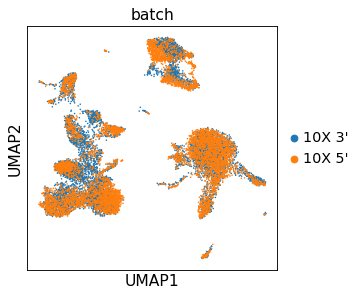

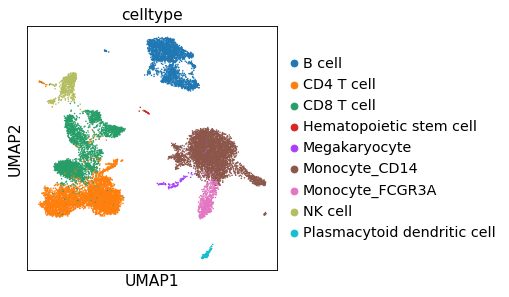

In [18]:
adata_seurat.obs['batch'] = ['10X 3\'' if i == 1.0 else '10X 5\'' for i in adata_seurat.obs['batch']]
sc.pl.umap(adata_seurat,color='batch',save='_figure3_seurat_batch.pdf')
sc.pl.umap(adata_seurat,color='celltype',save='_figure3_seurat_celltype.pdf')

In [19]:
adata_seurat.__dict__['_raw'].__dict__['_var'] = adata_seurat.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

In [20]:
adata_seurat.write('./processed_adata/adata_seurat_fig3.h5ad')

# Batch correction using harmony

In [21]:
adata_harmony = sc.read_h5ad('/media/bgi/zhouruilong/genebank/zfssz2/ST_MCHRI/BIGDATA/USER/zhangtongda/ldfssz1_ztd_project/project/ZB_single_cell/20210610/fig3_harmony/batches.h5ad')

In [22]:
adata_harmony.obsm['X_pca'] = adata_harmony.obsm['X_harmony']
adata_harmony.obs['celltype'] = adata_harmony.obs['CellType']
del adata_harmony.obs['CellType']
sc.pp.neighbors(adata_harmony)
sc.tl.umap(adata_harmony)

asw_harmony = silhouette_coeff_ASW(adata_harmony)
entropy_harmony = compute_entropy(adata_harmony)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)


Calculating entropy ...
use exist neighbors
Entropy calculated!


... storing 'Sample' as categorical
... storing 'batch' as categorical
... storing 'anno' as categorical
... storing 'Method' as categorical
... storing 'batchlb' as categorical
... storing 'celltype' as categorical


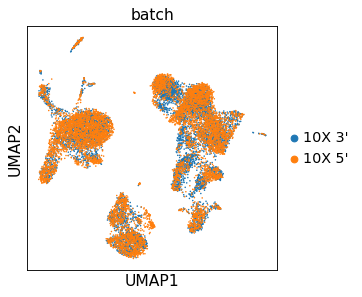

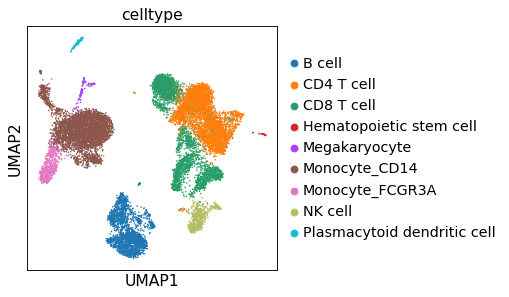

In [23]:
adata_harmony.obs['batch'] = ['10X 3\'' if i == 1.0 else '10X 5\'' for i in adata_harmony.obs['batch']]
sc.pl.umap(adata_harmony,color='batch',save='_figure3_harmony_batch.pdf')
sc.pl.umap(adata_harmony,color='celltype',save='_figure3_harmony_celltype.pdf')

In [24]:
adata_harmony

AnnData object with n_obs × n_vars = 15476 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'cell', 'batchlb', 'celltype'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'umap', 'batch_colors', 'celltype_colors'
    obsm: 'X_harmony', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances', 'connectivities'

In [25]:
adata_harmony.write('./processed_adata/adata_harmony_fig3.h5ad')

# Batch correction using MMD

In [32]:
asw_MMD = pd.read_csv('/media/bgi/zhouruilong/deepMNN/csv_result/fig3/asw_MMD_fig3.csv')
entropy_MMD = pd.read_csv('/media/bgi/zhouruilong/deepMNN/csv_result/fig3/entropy_MMD_fig3.csv')

# Batch correction using scGen

In [33]:
asw_scgen = pd.read_csv('/media/bgi/zhouruilong/deepMNN/csv_result/fig3/asw_scgen_fig3.csv')
entropy_scgen = pd.read_csv('/media/bgi/zhouruilong/deepMNN/csv_result/fig3/entropy_scgen_fig3.csv')

# Save metrics

In [34]:
#Raw
asw_raw.to_csv('./csv_result/fig3/asw_raw_fig3.csv',index=0)
entropy_raw.to_csv('./csv_result/fig3/entropy_raw_fig3.csv',index=0)

#MMD-ResNet
asw_MMD.to_csv('./csv_result/fig3/asw_MMD_fig3.csv',index=0)
entropy_MMD.to_csv('./csv_result/fig3/entropy_MMD_fig3.csv',index=0)

#scGen
asw_scgen.to_csv('./csv_result/fig3/asw_scgen_fig3.csv',index=0)
entropy_scgen.to_csv('./csv_result/fig3/entropy_scgen_fig3.csv',index=0)

#Seurat V4
asw_seurat.to_csv('./csv_result/fig3/asw_seurat_fig3.csv',index=0)
entropy_seurat.to_csv('./csv_result/fig3/entropy_seurat_fig3.csv',index=0)

#Harmony
asw_harmony.to_csv('./csv_result/fig3/asw_harmony_fig3.csv',index=0)
entropy_harmony.to_csv('./csv_result/fig3/entropy_harmony_fig3.csv',index=0)

#Scanorama
asw_Scanorama.to_csv('./csv_result/fig3/asw_Scanorama_fig3.csv',index=0)
entropy_Scanorama.to_csv('./csv_result/fig3/entropy_Scanorama_fig3.csv',index=0)

#deepMNN
asw_deepMNN.to_csv('./csv_result/fig3/asw_deepMNN_fig3.csv',index=0)
entropy_deepMNN.to_csv('./csv_result/fig3/entropy_deepMNN_fig3.csv',index=0)

# Metrics

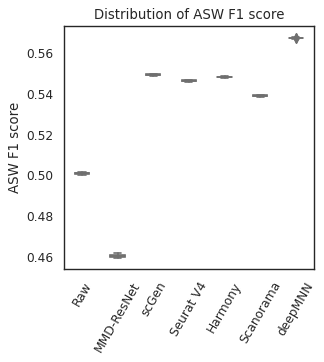

In [46]:
asw_df = pd.DataFrame()
asw_df['ASW F1 score'] = asw_raw['fscore'].tolist() + asw_MMD['fscore'].tolist() + asw_scgen['fscore'].tolist() + asw_seurat['fscore'].tolist() + asw_harmony['fscore'].tolist() + asw_Scanorama['fscore'].tolist() + asw_deepMNN['fscore'].tolist() 
asw_df['Methods'] = (['Raw'] * asw_raw.shape[0] + 
                     ['MMD-ResNet'] * asw_raw.shape[0] + 
                     ['scGen'] * asw_raw.shape[0] +
                     ['Seurat V4'] * asw_raw.shape[0] +
                     ['Harmony'] * asw_raw.shape[0] +
                     ['Scanorama'] * asw_raw.shape[0] +
                     ['deepMNN'] * asw_raw.shape[0])

# plt.figure(dpi=300)

sns.set_theme(style='white', palette='pastel')
sns.boxplot(x='Methods', y='ASW F1 score', width=0.4, data=asw_df)
plt.title('Distribution of ASW F1 score')
plt.xlabel('')
plt.xticks(rotation=60)
plt.savefig('figures/ASW_F1_score_figure3.pdf', format='pdf', dpi=300, bbox_inches='tight')

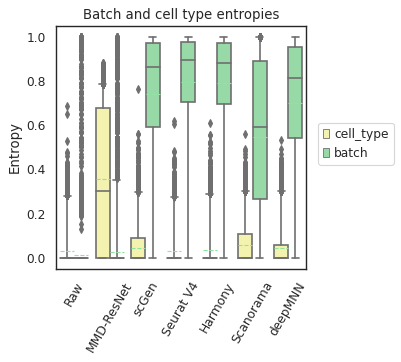

In [45]:
entropy_df = pd.DataFrame()
entropy_df['Entropy'] = (entropy_raw['cell_type'].tolist() + entropy_raw['batch'].tolist() + 
                         entropy_MMD['cell_type'].tolist() + entropy_MMD['batch'].tolist() +
                         entropy_scgen['cell_type'].tolist() + entropy_scgen['batch'].tolist() + 
                         entropy_seurat['cell_type'].tolist() + entropy_seurat['batch'].tolist() +
                         entropy_harmony['cell_type'].tolist() + entropy_harmony['batch'].tolist() +
                         entropy_Scanorama['cell_type'].tolist() + entropy_Scanorama['batch'].tolist() +
                         entropy_deepMNN['cell_type'].tolist() + entropy_deepMNN['batch'].tolist())

entropy_df['Methods'] = (['Raw'] * entropy_raw.shape[0] * 2 + 
                         ['MMD-ResNet'] * entropy_raw.shape[0] * 2 + 
                         ['scGen'] * entropy_raw.shape[0] * 2 +
                         ['Seurat V4'] * entropy_raw.shape[0] * 2 +
                         ['Harmony'] * entropy_raw.shape[0] * 2 +
                         ['Scanorama'] * entropy_raw.shape[0] * 2 +
                         ['deepMNN'] * entropy_raw.shape[0] * 2)

entropy_df['Entropy_type'] = (['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] + 
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] + 
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] +
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] +
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] +
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] +
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0])

# plt.figure(dpi=300)

sns.set_theme(style='white', palette="pastel")

sns.boxplot(x='Methods', y='Entropy', whis=(2.5,97.5), showmeans=True, meanline=True,
            hue='Entropy_type', palette=['y', 'g'], data=entropy_df)
plt.title('Batch and cell type entropies')
plt.xlabel('')
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor=(1.05, 0.6), borderaxespad=0)
plt.savefig('figures/Entropy_figure3.pdf', format='pdf', dpi=300, bbox_inches='tight')